In [42]:
# Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn import datasets
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
import xgboost as xgb

import seaborn as sns

%matplotlib inline 
from matplotlib.colors import LogNorm
sns.set()

# Style options for plots.
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('figure', figsize=(15, 6))

# Style options for pandas
pd.set_option('display.max_columns', None)

# Pompage des données

## Nombre de Véhicules par Commune par Trimestre entre 2001 et 2021

In [43]:
# Nombre de Véhicules Electriques niveau national
df_france = pd.DataFrame({'Year':[i for i in range(2001,2023)],'Nb_VE':[0.4,0.3,0.1,0.5,0.006,0.014,0.001,0,0.01,0.2,2.6,5.7,8.8,10.6,17.3,21.8,24.9,31.1,42.8,110.9,162.1,202.9]})
df_france['Nb_VE'] = df_france['Nb_VE']*1000
df_france.tail(2)

,Year,Nb_VE
20,2021,162100.00
21,2022,202900.00


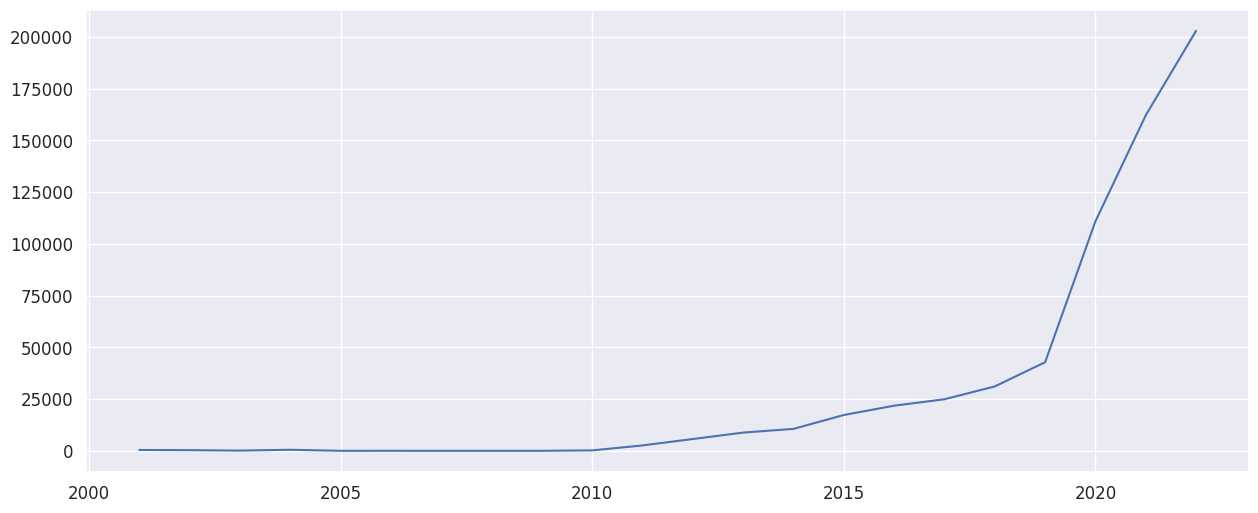

In [44]:
plt.plot(df_france['Year'],df_france['Nb_VE'])

In [5]:
# Nombre de Véhicules Electriques niveau communale
df_comm = pd.read_csv('./data/voitures.csv',sep=";")
# drop useless columns
df_comm.drop(['codgeo','epci','libepci','nb_vp_rechargeables_gaz','nb_vp','commune_geom','commune_centroid'],axis=1,inplace=True)
# convert date column
df_comm['date_arrete'] =  pd.to_datetime(df_comm['date_arrete'])
# keep only 2021
df_comm = df_comm[df_comm['date_arrete'].dt.year == 2021]
df_comm.tail(2)
# Note: pour les 32751 communes on a 140711 values = 32751 * 4
# convert to float
df_comm['nb_vp_rechargeables_el']= df_comm["nb_vp_rechargeables_el"].astype(float)
df_comm['nb_vp_rechargeables_el'] = df_comm['nb_vp_rechargeables_el'] / df_comm['nb_vp_rechargeables_el'].sum() * 100
# Pivot table
df_comm = df_comm.pivot_table(values = 'nb_vp_rechargeables_el', columns = 'libgeo', index = 'date_arrete')
# Interpolation des nombres de véhicules electriques sur les anciennes années
for date in pd.date_range("2001-03","2021-01",freq="3M"):
    row = df_comm.xs("2021-03")
    if date.month == 6:
        row = df_comm.xs("2021-06")
    if date.month == 9:
        row = df_comm.xs("2021-09")
    if date.month == 12:
        row = df_comm.xs("2021-12")
    row.index = [date]
    row.name = date
    df_comm = pd.concat([df_comm,row])
for index, row in df_comm.iterrows():
    df_comm.loc[index] *= df_france[df_france['Year'] == index.year]['Nb_VE'].values[0]
# Sort by date
df_comm = df_comm.sort_index()


df_comm.tail(3)

In [45]:
df_comm = pd.read_csv('./data/ve_par_commune.csv')
df_comm.libgeo=df_comm.libgeo.str.lower()
df_comm.head()

,libgeo,date_arrete,nb_vp_rechargeables_el
0,aast,2014-03-31,0.12
1,aast,2014-06-30,0.10
2,aast,2014-09-30,0.09
3,aast,2014-12-31,0.08
4,aast,2015-03-31,0.21


In [46]:
df_cluster=pd.read_csv('./Cluster/data_commune_cluster.csv')
df_cluster=df_cluster[['LIBGEO','cluster','rurality','population','com_life_level']]
df_cluster.LIBGEO=df_cluster.LIBGEO.str.lower()
# df_cluster.drop(['Unnamed: 0','Unnamed: 0.1','codgeo','libgeo','Typologie urbain/rural','latitude','longitude'],axis=1,inplace=True)
df_cluster.head()

,LIBGEO,cluster,rurality,population,com_life_level
0,l'abergement-clémenciat,3,1,771,21577.00
1,l'abergement-de-varey,6,0,253,21673.00
2,ambérieu-en-bugey,35,4,14204,19756.00
3,ambérieux-en-dombes,3,2,1720,23205.00
4,ambléon,3,0,112,22158.00


In [47]:
data=df_cluster.merge(df_comm,how='left',right_on='libgeo',left_on='LIBGEO')
data.head()

,LIBGEO,cluster,rurality,population,com_life_level,libgeo,date_arrete,nb_vp_rechargeables_el
0,l'abergement-clémenciat,3,1,771,21577.00,l'abergement-clémenciat,2014-03-31,0.35
1,l'abergement-clémenciat,3,1,771,21577.00,l'abergement-clémenciat,2014-06-30,0.30
2,l'abergement-clémenciat,3,1,771,21577.00,l'abergement-clémenciat,2014-09-30,0.27
3,l'abergement-clémenciat,3,1,771,21577.00,l'abergement-clémenciat,2014-12-31,0.31
4,l'abergement-clémenciat,3,1,771,21577.00,l'abergement-clémenciat,2015-03-31,0.62


In [48]:
# drop nan values
data.dropna(inplace=True)
# drop useless columns
data.drop(['libgeo'],axis=1,inplace=True)
# convert date column
data.date_arrete=pd.to_datetime(data.date_arrete)
# create year column
data['year']=data.date_arrete.dt.year

In [50]:
data.head(2)

,LIBGEO,cluster,rurality,population,com_life_level,date_arrete,nb_vp_rechargeables_el,year
0,l'abergement-clémenciat,3,1,771,21577.00,2014-03-31,0.35,2014
1,l'abergement-clémenciat,3,1,771,21577.00,2014-06-30,0.30,2014


## Nombre de bornes par commune 

In [51]:
# Nombre des bornes
df_bornes = pd.read_csv("./data/bornes_par_commune_par_année.csv")
df_bornes

,year,commune,nbre_pdc,total_bornes
0,2015,boulleret,2.00,2.00
1,2015,chezal-benoît,2.00,2.00
2,2015,méreau,2.00,2.00
3,2015,neuvy-sur-barangeon,2.00,2.00
4,2015,aix-en-provence,1.00,1.00
...,...,...,...,...
55395,2023,wormhout,0.00,1.00
55396,2023,échirolles,0.00,1.00
55397,2023,épernay-sous-gevrey,0.00,1.00
55398,2023,épinal,0.00,1.00


In [55]:
data.columns

Index(['LIBGEO', 'cluster', 'rurality', 'population', 'com_life_level',
       'date_arrete', 'nb_vp_rechargeables_el', 'year'],
      dtype='object')

In [64]:
data =data.merge(df_bornes,how='left',right_on=['commune','year'],left_on=['LIBGEO','year'])
data.head()

,LIBGEO,cluster,rurality,population,com_life_level,date_arrete,nb_vp_rechargeables_el,year,commune,nbre_pdc,total_bornes
0,l'abergement-clémenciat,3,1,771,21577.00,2014-03-31,0.35,2014,NaN,NaN,NaN
1,l'abergement-clémenciat,3,1,771,21577.00,2014-06-30,0.30,2014,NaN,NaN,NaN
2,l'abergement-clémenciat,3,1,771,21577.00,2014-09-30,0.27,2014,NaN,NaN,NaN
3,l'abergement-clémenciat,3,1,771,21577.00,2014-12-31,0.31,2014,NaN,NaN,NaN
4,l'abergement-clémenciat,3,1,771,21577.00,2015-03-31,0.62,2015,NaN,NaN,NaN


In [65]:
len(df_bornes.commune.unique())

5266

In [66]:
len(data.LIBGEO.unique())

28872

## Emissions du CO2 en france
http://www.globalcarbonatlas.org/fr/CO2-emissions

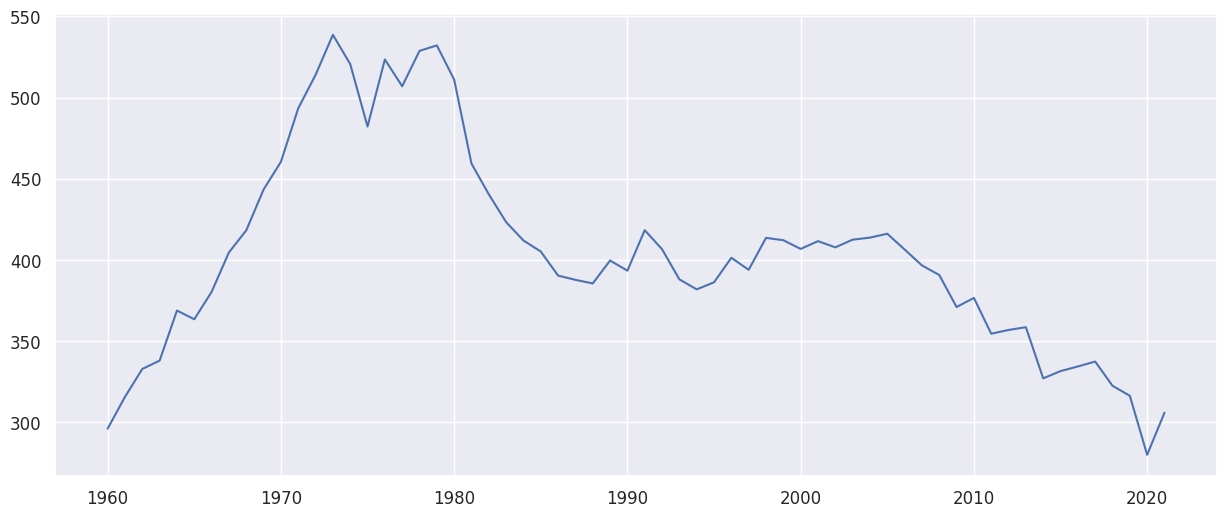

In [68]:
# Émission en MtCO2 en france
df_co2 = pd.read_csv('./data/Emmision_1960-2021.csv',sep=';')
plt.plot(df_co2['année'],df_co2['emissions'])

In [69]:
# add a line to the dataframe
df_co2.loc[len(df_co2)] = [2022,df_co2['emissions'].iloc[-1]]

In [70]:
data=data.merge(df_co2,how='left',left_on='year',right_on='année')
data.drop(['année'],axis=1,inplace=True)
data.head()

,LIBGEO,cluster,rurality,population,com_life_level,date_arrete,nb_vp_rechargeables_el,year,commune,nbre_pdc,total_bornes,emissions
0,l'abergement-clémenciat,3,1,771,21577.00,2014-03-31,0.35,2014,NaN,NaN,NaN,327.11
1,l'abergement-clémenciat,3,1,771,21577.00,2014-06-30,0.30,2014,NaN,NaN,NaN,327.11
2,l'abergement-clémenciat,3,1,771,21577.00,2014-09-30,0.27,2014,NaN,NaN,NaN,327.11
3,l'abergement-clémenciat,3,1,771,21577.00,2014-12-31,0.31,2014,NaN,NaN,NaN,327.11
4,l'abergement-clémenciat,3,1,771,21577.00,2015-03-31,0.62,2015,NaN,NaN,NaN,331.58


## Trafic routier journalier annuel 
https://www.data.gouv.fr/en/datasets/trafic-moyen-journalier-annuel-sur-le-reseau-routier-national/

In [71]:
def merge_data():
    paths = ['./data/TMJA/TMJA_'+str(i)+'.csv' for i in range(2007,2017)]+['./data/TMJA/tmja-2017.csv','./data/TMJA/tmja2018.csv','./data/TMJA/tmja-2019.csv']
    df = pd.concat([pd.read_csv(path,sep='\t') for path in paths]+[pd.read_csv('./data/TMJA/tmja-2017.csv',sep='\t'),pd.read_csv('./data/TMJA/tmja2018.csv',sep='\t'),pd.read_csv('./data/TMJA/tmja-2019.csv',sep=';')], ignore_index=True)
    # convert date to year
    df['dateReferentiel'] =  pd.to_datetime(df['dateReferentiel']).dt.year
    # goupe by year and department over routes
    df = df.groupby(['dateReferentiel','depPrD']).mean()
    # remove useless columns
    df.drop(['prD','zD','prF','zF','depPrF','anneeMesureTrafic'],axis=1,inplace=True)
    df.to_csv('./data/TMJA_2007-2019.csv')
    df.reset_index(inplace=True)
    # fill nan values with mean
    df.TMJA.fillna(df.TMJA.mean(),inplace=True)
    # add a 96 row to the dataframe 
    for year in [2020,2021,2022]:
        for dep in df.depPrD.unique():
            df.loc[len(df)] = [year,dep,df[df['depPrD'] == dep]['TMJA'].mean()]
    #  use this dataset to get the commune from department codes
    commune_depart=pd.read_csv('./data/communes-departement-region.csv')
    commune_depart=commune_depart[['nom_commune_complet','code_departement']]
    commune_depart.nom_commune_complet=commune_depart.nom_commune_complet.str.lower()
    # merge the two datasets
    df.depPrD=df.depPrD.astype(int).astype(str)
    df=df.merge(commune_depart,how='left',left_on='depPrD',right_on='code_departement')
    # remove useless columns
    df=df[['dateReferentiel','nom_commune_complet','TMJA']]
    return df
df_tmja = merge_data()
df_tmja.tail(2)

,dateReferentiel,nom_commune_complet,TMJA
612910,2022.00,villiers-le-sec,82589.46
612911,2022.00,wy-dit-joli-village,82589.46


In [72]:
# manque cluster 4 et 12
data = data.merge(df_tmja,how='left',left_on=['LIBGEO','year'],right_on=['nom_commune_complet','dateReferentiel'])
data.head()

,LIBGEO,cluster,rurality,population,com_life_level,date_arrete,nb_vp_rechargeables_el,year,commune,nbre_pdc,total_bornes,emissions,dateReferentiel,nom_commune_complet,TMJA
0,l'abergement-clémenciat,3,1,771,21577.00,2014-03-31,0.35,2014,NaN,NaN,NaN,327.11,2014.00,l'abergement-clémenciat,28156.13
1,l'abergement-clémenciat,3,1,771,21577.00,2014-06-30,0.30,2014,NaN,NaN,NaN,327.11,2014.00,l'abergement-clémenciat,28156.13
2,l'abergement-clémenciat,3,1,771,21577.00,2014-09-30,0.27,2014,NaN,NaN,NaN,327.11,2014.00,l'abergement-clémenciat,28156.13
3,l'abergement-clémenciat,3,1,771,21577.00,2014-12-31,0.31,2014,NaN,NaN,NaN,327.11,2014.00,l'abergement-clémenciat,28156.13
4,l'abergement-clémenciat,3,1,771,21577.00,2015-03-31,0.62,2015,NaN,NaN,NaN,331.58,2015.00,l'abergement-clémenciat,29473.83


In [73]:
data.drop(['LIBGEO','year','dateReferentiel','nom_commune_complet'],axis=1,inplace=True)
data.head()

,cluster,rurality,population,com_life_level,date_arrete,nb_vp_rechargeables_el,commune,nbre_pdc,total_bornes,emissions,TMJA
0,3,1,771,21577.00,2014-03-31,0.35,NaN,NaN,NaN,327.11,28156.13
1,3,1,771,21577.00,2014-06-30,0.30,NaN,NaN,NaN,327.11,28156.13
2,3,1,771,21577.00,2014-09-30,0.27,NaN,NaN,NaN,327.11,28156.13
3,3,1,771,21577.00,2014-12-31,0.31,NaN,NaN,NaN,327.11,28156.13
4,3,1,771,21577.00,2015-03-31,0.62,NaN,NaN,NaN,331.58,29473.83


## Jointure des données

In [74]:
# aggréger par cluster
df_cluster_ve = data.groupby(['cluster','date_arrete']).mean()
df_cluster_ve = df_cluster_ve.reset_index()

In [75]:
df_cluster_ve['annee'] = df_cluster_ve.date_arrete.dt.year
df_cluster_ve['mois'] = df_cluster_ve.date_arrete.dt.month
df_cluster_ve.drop(['date_arrete'],axis=1,inplace=True)

In [76]:
df_cluster_ve['nb_vp_rechargeables_el'] = df_cluster_ve['nb_vp_rechargeables_el'].astype(int)
df_cluster_ve.head()

,cluster,rurality,population,com_life_level,nb_vp_rechargeables_el,nbre_pdc,total_bornes,emissions,TMJA,annee,mois
0,0,3.26,1257.56,21627.92,0,0.00,27.35,327.11,19897.56,2014,3
1,0,3.26,1257.56,21627.92,0,0.00,27.35,327.11,19897.56,2014,6
2,0,3.26,1257.56,21627.92,0,0.00,27.35,327.11,19897.56,2014,9
3,0,3.26,1257.56,21627.92,0,0.00,27.35,327.11,19897.56,2014,12
4,0,3.26,1257.56,21627.92,1,0.00,27.35,331.58,22002.01,2015,3


In [77]:
df_cluster_ve["nb_ve"] = df_cluster_ve["nb_vp_rechargeables_el"]
df_cluster_ve.drop(['nb_vp_rechargeables_el'],axis=1,inplace=True)

In [78]:
df_cluster_ve.drop(['cluster'],axis=1,inplace=True)

In [80]:
df_cluster_ve.drop(['nbre_pdc'],axis=1,inplace=True)

<AxesSubplot: >

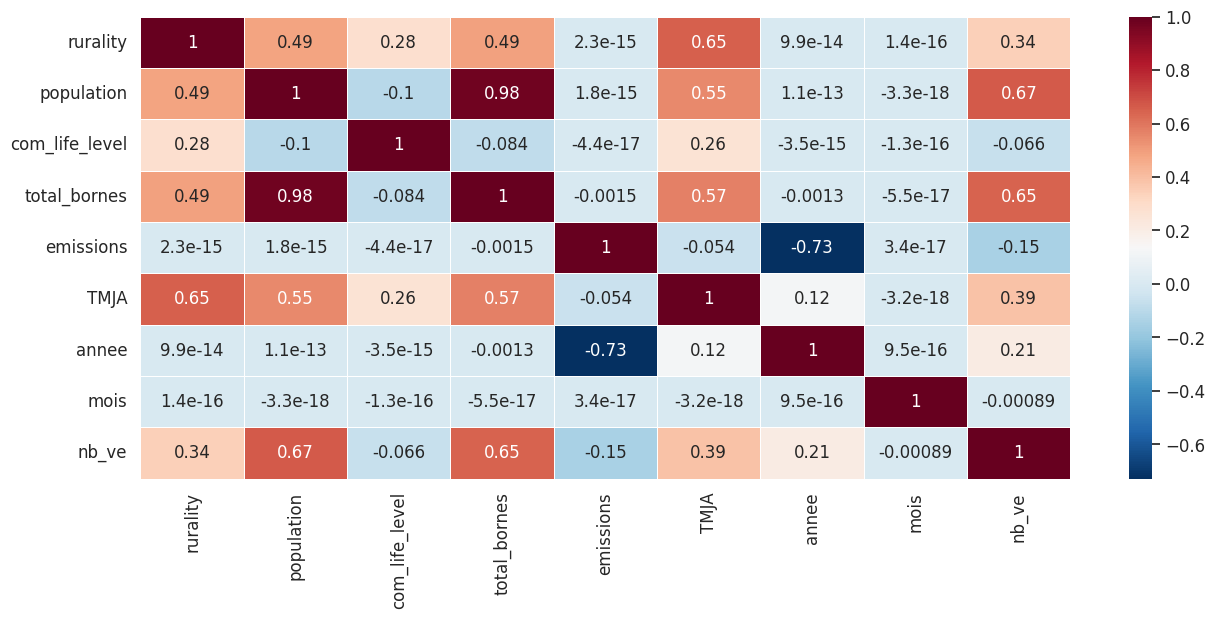

In [81]:
sns.heatmap(df_cluster_ve.corr(), 
            xticklabels=df_cluster_ve.corr().columns,
            yticklabels=df_cluster_ve.corr().columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

# Prediction du nombre des véhicules

In [85]:
train, test = train_test_split(df_cluster_ve, test_size=0.3, random_state=42)

In [86]:
X = train.drop(['nb_ve'],axis=1)
y_train = train['nb_ve']
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X)
X_test= scaler.transform(test.drop(['nb_ve'],axis=1))
y_test = test['nb_ve']

In [87]:

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

 14%|█▍        | 6/42 [00:00<00:00, 56.70it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


100%|██████████| 42/42 [00:29<00:00,  1.44it/s]


In [88]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,1.00,1.00,8.37,0.16
XGBRegressor,1.00,1.00,12.66,0.39
GradientBoostingRegressor,1.00,1.00,14.87,0.22
ExtraTreeRegressor,1.00,1.00,32.41,0.01
DecisionTreeRegressor,0.99,0.99,52.97,0.01
RandomForestRegressor,0.98,0.98,72.44,0.33
BaggingRegressor,0.98,0.98,84.57,0.04
PoissonRegressor,0.97,0.97,102.37,0.03
GaussianProcessRegressor,0.96,0.96,118.89,0.12


In [89]:
# create a Decition Tree model on the training data
from sklearn.tree import DecisionTreeRegressor
# Fit regression model
regr_1 = DecisionTreeRegressor()
regr_1.fit(X_train, y_train)
# Predict
y_1 = regr_1.predict(X_test)

In [90]:
rmse = np.sqrt(mean_squared_error(y_test, y_1))
rmse

52.968934567320495

In [91]:
from sklearn.model_selection import GridSearchCV
from IPython.display import display, clear_output
def grid_search(name, model, params, verbose=False, cv=5):
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_root_mean_squared_error', verbose=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    clear_output()
    display()
    print(f'[{name}]')
    print(f'best RMSE: {-grid_search.best_score_:.2f}')
    print(f'best hyperparams: {grid_search.best_params_}')
    return grid_search
grid_search_random_forest = grid_search('DecisionTreeRegressor', DecisionTreeRegressor(), params={
    'max_depth': [1,3,5,7,9,11,12],
    'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10]})

[DecisionTreeRegressor]
best RMSE: 67.64
best hyperparams: {'max_depth': 9, 'min_samples_leaf': 1}


In [103]:
grid_search_random_forest = grid_search('RandomForestRegressor', RandomForestRegressor(), params={
    'n_estimators': [50, 100, 10],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5]})

[RandomForestRegressor]
best RMSE: 76.35
best hyperparams: {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}


In [93]:
predictions = grid_search_random_forest.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
rmse

74.90628965369797

In [94]:
grid_search_random_forest

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 10]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [95]:
# import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
grid_search_gradient_boosting = grid_search('GradientBoostingRegressor', GradientBoostingRegressor(), params={
    'n_estimators': [50, 100,500],
    'learning_rate': [0.8,0.9,1, 1.1, 1.2],
    'max_depth': [2, 3, 5],
})


[GradientBoostingRegressor]
best RMSE: 64.79
best hyperparams: {'learning_rate': 0.8, 'max_depth': 5, 'n_estimators': 50}


In [96]:
predictions = grid_search_gradient_boosting.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
rmse

37.615380368404814

In [97]:
# initialize and fit the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

X_test_scaled = scaler.transform(test.drop(['nb_ve'],axis=1))
y_test = test['nb_ve']
# make predictions
predictions = model.predict(X_test_scaled)
# compute the rmse
rmse = np.sqrt(mean_squared_error(y_test, predictions))
rmse

73.97911697676446

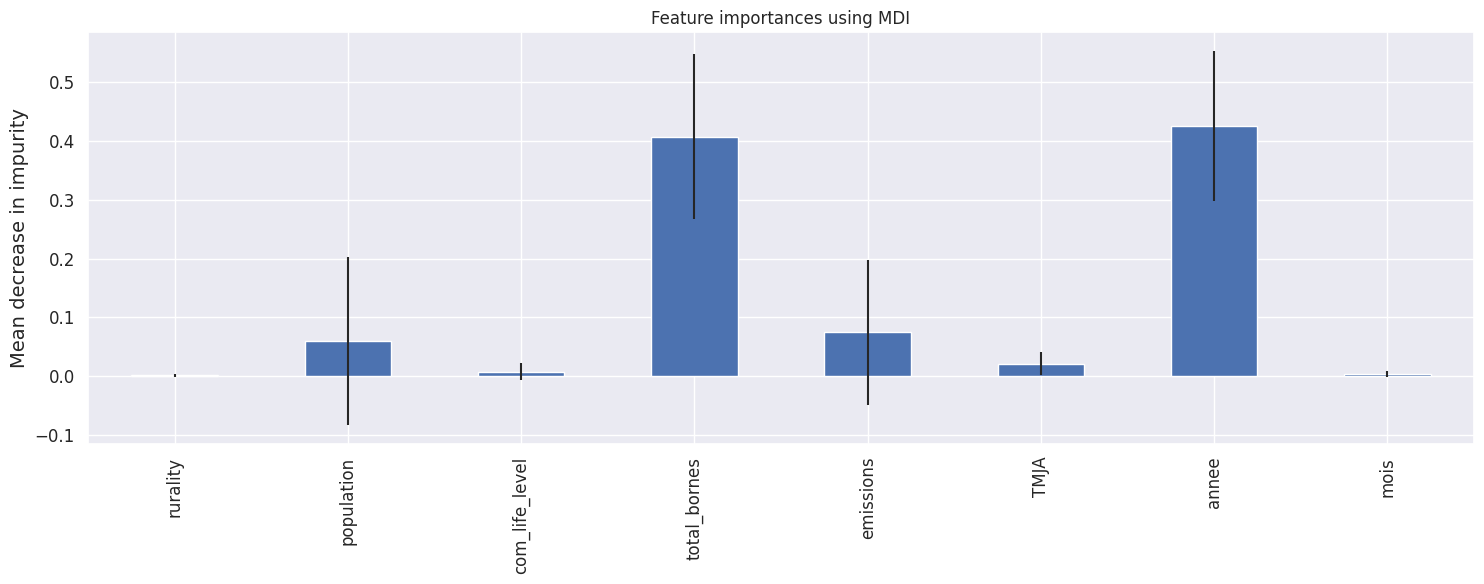

In [98]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

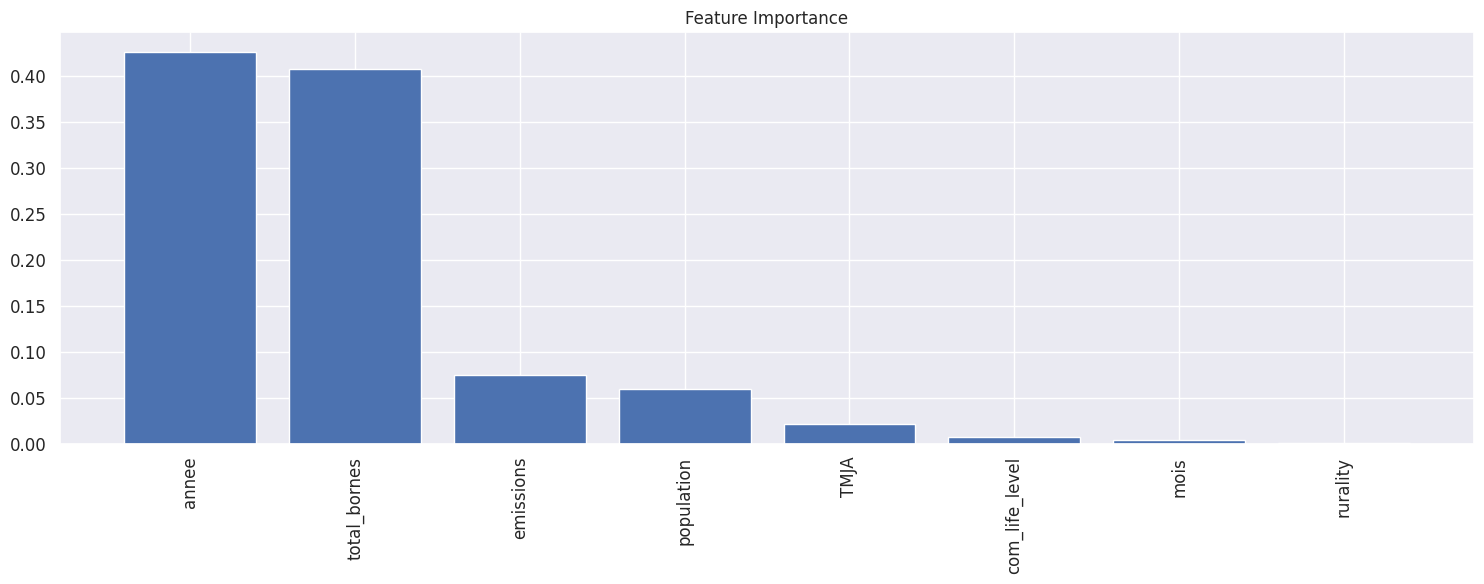

In [99]:
importances = model.feature_importances_
# Sort the feature importance in descending order

sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [112]:
X = df_cluster_ve.drop(['nb_ve'],axis=1)
y = df_cluster_ve['nb_ve']
# create an xgboost regression model
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__

Mean RMSE: 5.629 (3.169)


In [113]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
rmse

12.662871495601733

In [114]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

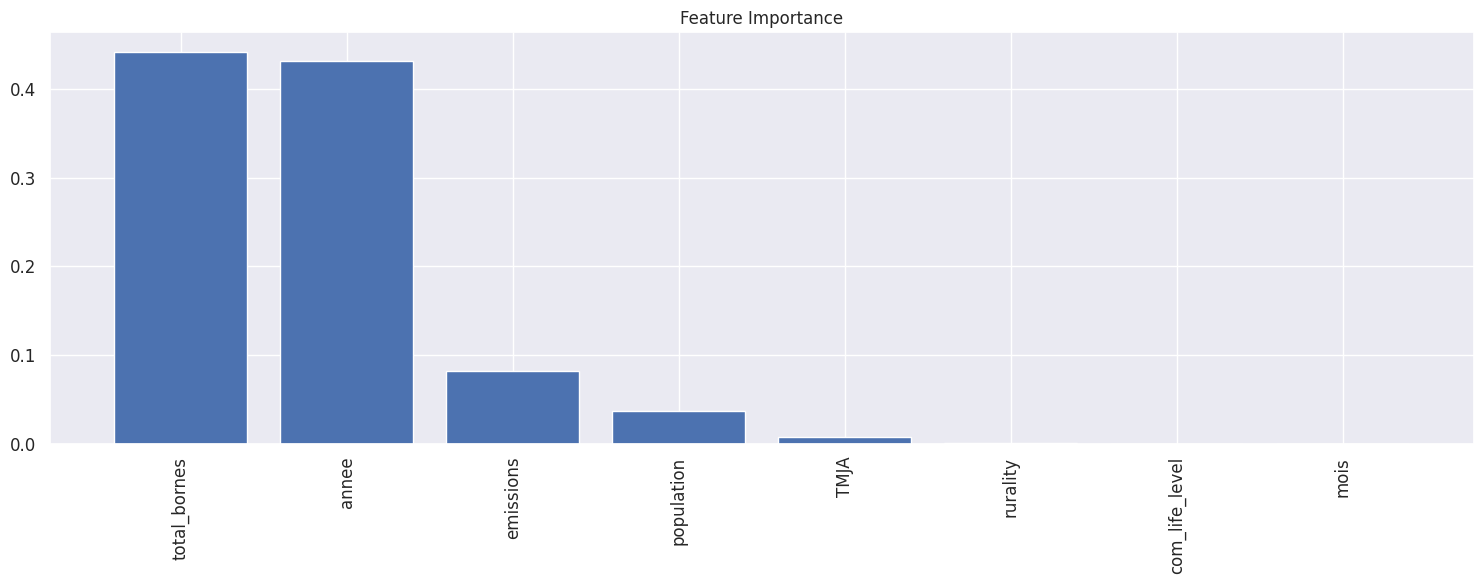

In [115]:
importances = model.feature_importances_
# Sort the feature importance in descending order

sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(X.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()